In [1]:
!which python

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/bin/python


In [2]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [3]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [4]:
vcfutils = "vcfutils.pl"
vcftools = "vcftools"
bcftools = "bcftools"
bgzip = "bgzip"
tabix = "tabix"
java = "java"
plink = "plink --noweb"

In [5]:
analysis_dir = '/data/gpfs/home/tfaske/d/frogs/ddocent/filtering'

In [6]:
cd $analysis_dir

/data/gpfs/assoc/denovo/tfaske/frogs/ddocent/filtering


In [7]:
vcf_file = os.path.join(analysis_dir, "TotalRawSNPs.vcf.gz")
assert os.path.exists(vcf_file)
vcf_file

'/data/gpfs/home/tfaske/d/frogs/ddocent/filtering/TotalRawSNPs.vcf.gz'

## keep only biallelic first

In [8]:
!$vcftools --remove-indels \
--min-alleles 2 \
--max-alleles 2 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_file \
--out $'RALU.biallelic'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/TotalRawSNPs.vcf.gz
	--recode-INFO-all
	--max-alleles 2
	--min-alleles 2
	--out RALU.biallelic
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 323 out of 323 Individuals
Outputting VCF file...
After filtering, kept 395007 out of a possible 496627 Sites
Run Time = 414.00 seconds


In [9]:
vcf_biallelic = os.path.join(analysis_dir, "RALU.biallelic.recode.vcf")
vcf_biallelic_gz = vcf_biallelic + '.gz'
!$bgzip -c $vcf_biallelic > {vcf_biallelic_gz}
!$tabix {vcf_biallelic_gz}

## Remove by MAF, missing, and thin next

In [10]:
!$vcftools \
--max-missing 0.6 \
--maf 0.02 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_biallelic_gz \
--out $'RALU_miss60_thin100_MAF2'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/RALU.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.02
	--thin 100
	--max-missing 0.6
	--out RALU_miss60_thin100_MAF2
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 323 out of 323 Individuals
Outputting VCF file...
After filtering, kept 22106 out of a possible 395007 Sites
Run Time = 51.00 seconds


In [11]:
!$vcftools \
--max-missing 0.7 \
--maf 0.02 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_biallelic_gz \
--out $'RALU_miss70_thin100_MAF2'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/RALU.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.02
	--thin 100
	--max-missing 0.7
	--out RALU_miss70_thin100_MAF2
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 323 out of 323 Individuals
Outputting VCF file...
After filtering, kept 20784 out of a possible 395007 Sites
Run Time = 49.00 seconds


In [12]:
vcf_filtered = "RALU_miss70_thin100_MAF2.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered

In [13]:
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Remove bad_indv


In [14]:
!$vcftools --gzvcf $vcf_filtered_gz --out $vcf_filtered_gz --missing-indv


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf RALU_miss70_thin100_MAF2.recode.vcf.gz
	--missing-indv
	--out RALU_miss70_thin100_MAF2.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 323 out of 323 Individuals
Outputting Individual Missingness
After filtering, kept 20784 out of a possible 20784 Sites
Run Time = 2.00 seconds


In [15]:
def get_imiss(vcf_file):
    imiss_file = !ls {vcf_file}.imiss
    imiss_df = pd.read_csv(imiss_file[0], sep="\t")
    imiss_df.index = imiss_df.INDV
    return imiss_df

In [16]:
imiss_df = get_imiss(vcf_filtered_gz)
imiss_df.head()

,INDV,N_DATA,N_GENOTYPES_FILTERED,N_MISS,F_MISS
INDV,,,,,
RL_AD1C_200,RL_AD1C_200,20784,0,1286,0.061874
RL_AD1C_201,RL_AD1C_201,20784,0,433,0.020833
RL_AD1C_202,RL_AD1C_202,20784,0,392,0.018861
RL_AD2C_203,RL_AD2C_203,20784,0,1356,0.065242
RL_AD2C_204,RL_AD2C_204,20784,0,400,0.019246


In [17]:
imiss_df.F_MISS.describe()

count    323.000000
mean       0.150702
std        0.253932
min        0.009430
25%        0.025091
50%        0.046959
75%        0.131183
max        0.999326
Name: F_MISS, dtype: float64

In [21]:
len(imiss_df),len(imiss_df[imiss_df.F_MISS >= .6]),len(imiss_df[imiss_df.F_MISS >= .5]), len(imiss_df[imiss_df.F_MISS >= .25])


(323, 26, 29, 46)

In [23]:
bad_indv = imiss_df.INDV[imiss_df.F_MISS >= .6]

In [24]:
with open(os.path.join(analysis_dir, "bad_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in bad_indv.index:
        o.write("%s\n" % elem)

In [25]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "bad_indv.txt")} \
--out {os.path.join(analysis_dir, "snps_indv_removed")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf RALU_miss70_thin100_MAF2.recode.vcf.gz
	--remove /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/bad_indv.txt
	--recode-INFO-all
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 297 out of 323 Individuals
Outputting VCF file...
After filtering, kept 20784 out of a possible 20784 Sites
Run Time = 21.00 seconds


In [26]:
vcf_bad_remove = os.path.join(analysis_dir, "snps_indv_removed.recode.vcf")
vcf_bad_remove_gz = vcf_bad_remove + ".gz"
!$bgzip -c {vcf_bad_remove} > {vcf_bad_remove_gz}
!$tabix {vcf_bad_remove_gz}

# Filter snps further 
this needs to be done after removing individuals


In [27]:
def get_vcf_stats(vcf_gz):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !$vcftools --gzvcf $vcf_gz \
        --out $vcf_gz \
        {"--%s" % stat} 

In [28]:
get_vcf_stats(vcf_bad_remove_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--depth
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Outputting Mean Depth by Individual
After filtering, kept 20784 out of a possible 20784 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--site-depth

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Outputting Depth for Each Site


After filtering, kept 20784 out of a possible 20784 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--site-mean-depth

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Outputting Depth for Each Site
After filtering, kept 20784 out of a possible 20784 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--site-quality

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Outputting Quality for Each Site


After filtering, kept 20784 out of a possible 20784 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--missing-site

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Outputting Site Missingness
After filtering, kept 20784 out of a possible 20784 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--freq
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Outputting Frequency Statistics...


After filtering, kept 20784 out of a possible 20784 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--counts
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Outputting Frequency Statistics...
After filtering, kept 20784 out of a possible 20784 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--hardy
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Outputting HWE statistics (but only for biallelic loci)


After filtering, kept 20784 out of a possible 20784 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--het
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Outputting Individual Heterozygosity
After filtering, kept 20784 out of a possible 20784 Sites
Run Time = 2.00 seconds


In [29]:
#pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    
    hardy_files = !ls {filedir}/{prefix}.hwe
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_files = !ls {filedir}/{prefix}.l* | grep -v log
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.ix[:,0:2]
    
    frq_files = !ls {filedir}/{prefix}.frq* | grep -v count
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    return loci_df, frq_df, hardy

In [30]:
vcf_bad_remove_gz

'/data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz'

In [31]:
loci_df, frq_df, hardy = combine_vcf_stats(analysis_dir,'snps_indv_removed.recode.vcf.gz')

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


RangeIndex(start=0, stop=6, step=1)


In [32]:
loci_df

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,QUAL,N_ALLELES,...,ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
dDocent_Contig_109-16,305305,450193771,1027.96000,460647.00000,594,0,0,0.000000,37573.500000,2,...,19.035410,3.396307e-07,1.000000e+00,2.478008e-07,C,T,0.797980,0.202020,0.202020,-0.251055
dDocent_Contig_156-11,328000,472002036,1104.38000,370832.00000,594,0,0,0.000000,301506.000000,2,...,223.728000,2.161918e-62,1.000000e+00,2.027941e-62,T,C,0.535354,0.464646,0.464646,-0.864780
dDocent_Contig_160-14,236545,249594353,796.44800,206752.00000,594,0,0,0.000000,313307.000000,2,...,232.993500,4.080681e-65,1.000000e+00,4.064197e-65,C,T,0.530303,0.469697,0.469697,-0.882540
dDocent_Contig_212-78,294044,383862802,990.04700,313329.00000,594,0,0,0.000000,2530.050000,2,...,0.360573,1.000000e+00,1.000000e+00,7.183592e-01,G,A,0.966330,0.033670,0.033670,-0.033101
dDocent_Contig_220-41,158221,111715447,532.73100,92656.30000,594,0,0,0.000000,3058.980000,2,...,1.027682,1.000000e+00,1.000000e+00,3.902908e-01,T,C,0.944444,0.055556,0.055556,-0.057041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dDocent_Contig_396255-35,830,4432,3.50211,6.46292,594,0,120,0.202020,0.047948,2,...,140.154700,8.440953e-11,8.440953e-11,1.000000e+00,A,T,0.962025,0.037975,0.037975,0.769493
dDocent_Contig_396263-18,1041,5737,3.81319,6.49806,594,0,48,0.080808,2370.400000,2,...,0.411256,7.021218e-01,7.867396e-01,3.441632e-01,G,A,0.802198,0.197802,0.197802,-0.036910
dDocent_Contig_396286-6,5349,111427,18.01010,50.98300,594,0,0,0.000000,1768.980000,2,...,8.282448,1.436292e-03,1.000000e+00,8.767035e-04,A,G,0.856902,0.143098,0.143098,-0.165029
dDocent_Contig_396287-2,1553,18101,6.21200,33.95090,594,0,94,0.158249,300.164000,2,...,2.213322,2.308508e-01,1.000000e+00,1.385372e-01,A,C,0.914000,0.086000,0.086000,-0.091904


In [33]:
frq_df

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
dDocent_Contig_109-16,dDocent_Contig_109,16,2,594,C:0.79798,T:0.20202
dDocent_Contig_156-11,dDocent_Contig_156,11,2,594,T:0.535354,C:0.464646
dDocent_Contig_160-14,dDocent_Contig_160,14,2,594,C:0.530303,T:0.469697
dDocent_Contig_212-78,dDocent_Contig_212,78,2,594,G:0.96633,A:0.03367
dDocent_Contig_220-41,dDocent_Contig_220,41,2,594,T:0.944444,C:0.0555556
...,...,...,...,...,...,...
dDocent_Contig_396255-35,dDocent_Contig_396255,35,2,474,A:0.962025,T:0.0379747
dDocent_Contig_396263-18,dDocent_Contig_396263,18,2,546,G:0.802198,A:0.197802
dDocent_Contig_396286-6,dDocent_Contig_396286,6,2,594,A:0.856902,G:0.143098
dDocent_Contig_396287-2,dDocent_Contig_396287,2,2,500,A:0.914,C:0.086


In [34]:
hardy

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
dDocent_Contig_109-16,dDocent_Contig_109,16,177/120/0,189.12/95.76/12.12,19.035410,3.396307e-07,1.000000e+00,2.478008e-07
dDocent_Contig_156-11,dDocent_Contig_156,11,21/276/0,85.12/147.76/64.12,223.728000,2.161918e-62,1.000000e+00,2.027941e-62
dDocent_Contig_160-14,dDocent_Contig_160,14,18/279/0,83.52/147.95/65.52,232.993500,4.080681e-65,1.000000e+00,4.064197e-65
dDocent_Contig_212-78,dDocent_Contig_212,78,277/20/0,277.34/19.33/0.34,0.360573,1.000000e+00,1.000000e+00,7.183592e-01
dDocent_Contig_220-41,dDocent_Contig_220,41,264/33/0,264.92/31.17/0.92,1.027682,1.000000e+00,1.000000e+00,3.902908e-01
...,...,...,...,...,...,...,...,...
dDocent_Contig_396255-35,dDocent_Contig_396255,35,226/4/7,219.34/17.32/0.34,140.154700,8.440953e-11,8.440953e-11,1.000000e+00
dDocent_Contig_396263-18,dDocent_Contig_396263,18,174/90/9,175.68/86.64/10.68,0.411256,7.021218e-01,7.867396e-01,3.441632e-01
dDocent_Contig_396286-6,dDocent_Contig_396286,6,212/85/0,218.08/72.84/6.08,8.282448,1.436292e-03,1.000000e+00,8.767035e-04
dDocent_Contig_396287-2,dDocent_Contig_396287,2,207/43/0,208.85/39.30/1.85,2.213322,2.308508e-01,1.000000e+00,1.385372e-01


In [35]:
loci_out = os.path.join(analysis_dir,'loci_out.csv')
frq_out = os.path.join(analysis_dir,'frq_out.csv')
hardy_out = os.path.join(analysis_dir,'hardy_out.csv')

loci_df.to_csv(path_or_buf=loci_out)
frq_df.to_csv(path_or_buf=frq_out)
hardy.to_csv(path_or_buf=hardy_out)


In [36]:
loci_df.SUM_DEPTH.describe()

count     20784.000000
mean       4612.489030
std       13649.576592
min         498.000000
25%        1076.000000
50%        1904.000000
75%        3671.250000
max      342977.000000
Name: SUM_DEPTH, dtype: float64

In [37]:
loci_df.QUAL.describe()

count    2.078400e+04
mean     6.984903e+03
std      3.922700e+04
min      0.000000e+00
25%      2.114525e+00
50%      6.256240e+02
75%      4.369460e+03
max      2.459980e+06
Name: QUAL, dtype: float64

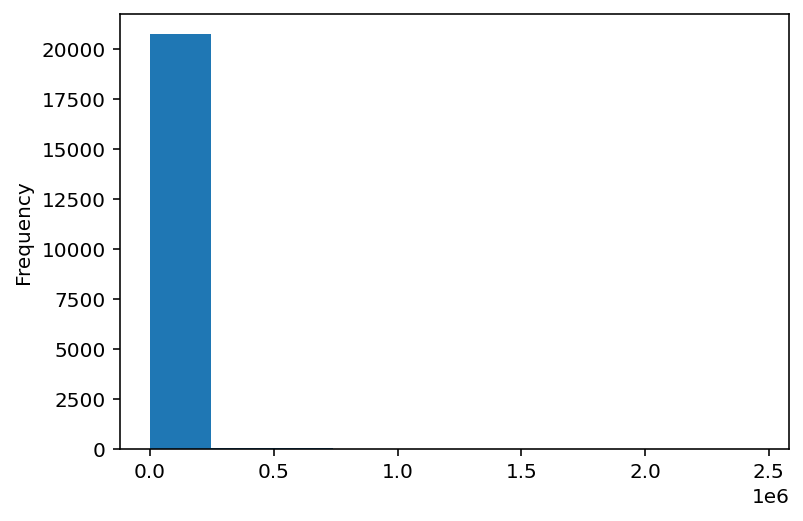

In [38]:
loci_df.QUAL.plot(kind="hist");

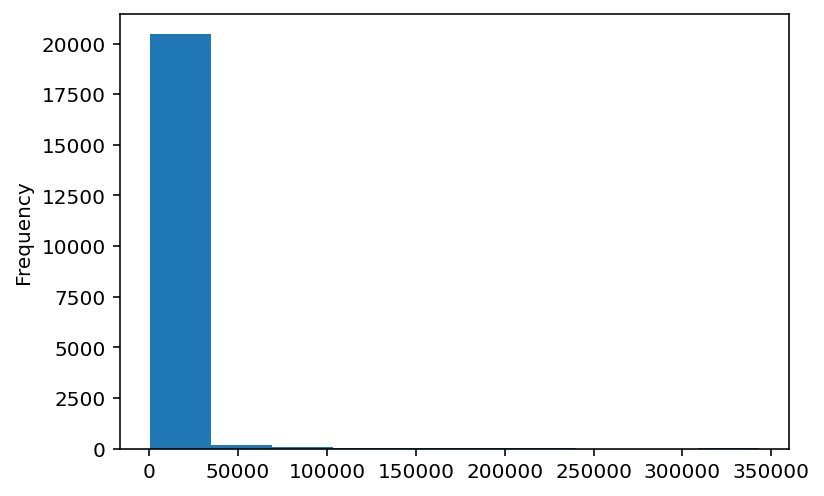

In [39]:
loci_df.SUM_DEPTH.plot(kind="hist");

In [40]:
len(loci_df[loci_df.Fis == -9])

0

In [41]:
len(loci_df[loci_df.SUM_DEPTH <5000]),len(loci_df[loci_df.SUM_DEPTH >=500])

(17187, 20783)

In [59]:
len(loci_df[loci_df.MEAN_DEPTH > 30]),len(loci_df[loci_df.MEAN_DEPTH >= 3])

(1858, 18717)

In [46]:
len(loci_df[loci_df.QUAL >= 10]) - len(loci_df[loci_df.QUAL >= 20])

273

In [54]:
len(loci_df[loci_df.QUAL <  200]), len(loci_df[loci_df.QUAL < 100]), len(loci_df[loci_df.QUAL < 20])

(8283, 7239, 5813)

In [51]:
 len(loci_df[loci_df.Fis <= -0.5]), len(loci_df[loci_df.MAF < 0.02])

(2217, 48)

In [64]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) &  
                  (df.Fis > -0.5)]
    else:
        return df[(df.MEAN_DEPTH >= 3) & 
                  (df.MEAN_DEPTH < 25) & 
                  (df.QUAL >= 50) & 
                  (df.MAF >= 0.02) &  
                  (df.Fis > -0.5)]

In [65]:
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(10067, 25)

In [66]:
with open(os.path.join(analysis_dir, "stage1_positions.txt"), "w") as o:
    for elem in loci_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))

In [67]:
!$vcftools --gzvcf $vcf_bad_remove_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "stage1_positions.txt")} \
--out {os.path.join(analysis_dir, "good_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/good_snps
	--positions /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/stage1_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Outputting VCF file...
After filtering, kept 10067 out of a possible 20784 Sites
Run Time = 11.00 seconds


In [68]:
snps = os.path.join(analysis_dir, "good_snps.recode.vcf")
snps_gz = snps + ".gz"
!$bgzip -c {snps} > {snps_gz}
!$tabix {snps_gz}

# Plink / chrom_map

In [69]:
chroms = sorted(set([x.split("-")[0] for x in loci_df.index]))
len(chroms) # number of unique contigs

20784

In [70]:
with open(os.path.join(analysis_dir, "chrom_map.txt"), "w") as o:
    for i, c in enumerate(chroms):
        o.write("%s\t%d\n" % (c, i))

In [71]:
def write_plink_files(vcf_gz):
    !$vcftools --gzvcf {vcf_gz} \
    --out {vcf_gz} \
    --plink \
    --chrom-map {os.path.join(analysis_dir, "chrom_map.txt")}

In [72]:
write_plink_files(snps_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/good_snps.recode.vcf.gz
	--chrom-map /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/chrom_map.txt
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/good_snps.recode.vcf.gz
	--plink

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Writing PLINK PED and MAP files ... 
	Read 20785 chromosome mapping file entries.
Done.
After filtering, kept 10067 out of a possible 10067 Sites
Run Time = 1.00 seconds


# Make 012

In [73]:
f = os.path.join(analysis_dir, "good_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/good_snps.recode.vcf
	--012
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/good_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 10067 out of a possible 10067 Sites
Run Time = 1.00 seconds


# Get coverage per individual

In [74]:
f = os.path.join(analysis_dir, "good_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/good_snps.recode.vcf
	--depth
	--out /data/gpfs/home/tfaske/d/frogs/ddocent/filtering/good_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 297 out of 297 Individuals
Outputting Mean Depth by Individual
After filtering, kept 10067 out of a possible 10067 Sites
Run Time = 0.00 seconds


In [75]:
depth_file = os.path.join(analysis_dir, "good_snps.recode.vcf.idepth")
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,RL_AD1C_200,9610,6.56431
1,RL_AD1C_201,9924,9.74688
2,RL_AD1C_202,9949,12.52700
3,RL_AD2C_203,9699,9.83967
4,RL_AD2C_204,9960,11.83330


In [76]:
depth_df.MEAN_DEPTH.describe()

count    297.000000
mean       8.719475
std        2.710802
min        2.138540
25%        7.020650
50%        9.222270
75%       10.866300
max       16.768300
Name: MEAN_DEPTH, dtype: float64

# Remove unnecessary files

In [77]:
!rm snps*

In [78]:
!rm *miss*

In [79]:
!rm *vcf